In [1]:
import os
import logging
import numpy as np

from scipy.spatial.transform import Rotation as R
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from PIL import Image
from pathlib import Path
from tqdm import tqdm
import json

import sys
import os

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
asset_dir = Path("./")
manifest_path = Path('ShapeNetCore.v2.json')
with open(manifest_path, 'rb') as manifest_file:
    assets = json.loads(manifest_file.read())['assets']
assets = {k: v for k, v in assets.items() if v['metadata']['category'] == 'car'}
asset_ids = list(assets.keys())

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 80
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddim-cars-128'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [5]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class AssetDataset(Dataset):
    def __init__(self, asset_ids, asset_dir, input_filename, target_filename, transform=None):
        self.asset_dir = asset_dir
        self.asset_ids = asset_ids
        self.input_filename = input_filename
        self.target_filename = target_filename
        self.transform = transform

    def __len__(self):
        return len(self.asset_ids)

    def __getitem__(self, idx):
        asset_path = self.asset_dir / self.asset_ids[idx]
        input_image = Image.open(asset_path / self.input_filename).convert('RGB')
        target_image = Image.open(asset_path / self.target_filename).convert('RGB')
        if self.transform is not None:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
        return input_image, target_image

In [6]:
def get_preprocessor(image_size):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

In [7]:
def get_filename(camera_angle, resolution):
    return f'color_angle{camera_angle}_res256x256.png'

In [8]:
from torch.utils.data import DataLoader

def makeDataLoader(seed=0, test_size=0.1, asset_ids=asset_ids, input_angle=30, target_angle=60, resolution=(256, 256), image_size=256, batch_size=16):
    train_ids, valid_ids = train_test_split(asset_ids, test_size=test_size, random_state=seed)
    input_filename = get_filename(input_angle, resolution)
    target_filename = get_filename(target_angle, resolution)
    preprocess = get_preprocessor(image_size)
    train_dataset = AssetDataset(asset_ids=train_ids, asset_dir=asset_dir,
                                 input_filename=input_filename,
                                 target_filename=target_filename,
                                 transform=preprocess)
    valid_dataset = AssetDataset(asset_ids=valid_ids, asset_dir=asset_dir,
                                 input_filename=input_filename,
                                 target_filename=target_filename,
                                 transform=preprocess)
    
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    
    train_size = len(train_dataset)
    valid_size = len(valid_dataset)
    
    return train_loader, valid_loader, train_size, valid_size

In [9]:
nonlinearity = F.silu

In [10]:
class DownBlock(nn.Module):
    def __init__(self, input_channels, layer_channels, is_last=False):
        super(DownBlock, self).__init__()
        self.input_layer = nn.Conv2d(input_channels,
                                     layer_channels[0],
                                     3, padding=1)
        self.layers = nn.ModuleList(nn.Conv2d(layer_channels[i], 
                                              layer_channels[i+1],
                                              3, padding=1)
                                    for i in range(len(layer_channels)-1))
        self.pool = nn.MaxPool2d(2, 2)
        self.is_last = is_last

    def forward(self, xb):
        output = nonlinearity(self.input_layer(xb))
        for layer in self.layers:
            output = nonlinearity(layer(output))
        if not self.is_last:
            output = self.pool(output)
        return output

In [11]:
class UpBlock(nn.Module):
    def __init__(self, output_channels, layer_channels, is_last=False):
        super(UpBlock, self).__init__()
        self.input_layer = nn.ConvTranspose2d(layer_channels[-1], layer_channels[-1], 2, stride=2)
        self.layers = nn.ModuleList(nn.Conv2d(layer_channels[i],
                                              layer_channels[i-1],
                                              3, padding=1)
                                    for i in range(len(layer_channels)-1, 0, -1))
        self.output_layer = nn.Conv2d(layer_channels[0], output_channels, 3, padding=1)
        self.is_last = is_last

    def forward(self, xb):
        output = nonlinearity(self.input_layer(xb))
        for layer in self.layers:
            output = nonlinearity(layer(output))
        output = self.output_layer(output)
        if not self.is_last:
            output = nonlinearity(output)
        return output

In [12]:
class Encoder(nn.Module):
    def __init__(self, layer_channels):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(DownBlock(layer_channels[i][-1],
                                              layer_channels[i+1])
                                    for i in range(len(layer_channels)-1))

    def forward(self, xb):
        output = xb
        for layer in self.layers:
            output = layer(output)
        return output

In [13]:
class MiddleBlock(nn.Module):
    def __init__(self, channels, image_size, bottleneck_channels):
        super(MiddleBlock, self).__init__()
        self.channels = channels
        self.image_size = image_size
        dim = channels * image_size * image_size
        self.input_layer = nn.Linear(dim, bottleneck_channels[0])
        self.layers = nn.ModuleList(nn.Linear(bottleneck_channels[i], 
                                              bottleneck_channels[i+1])
                                    for i in range(len(bottleneck_channels)-1))
        self.output_layer = nn.Linear(bottleneck_channels[-1], dim)

    def forward(self, xb):
        output = torch.flatten(xb, 1)
        output = nonlinearity(self.input_layer(output))
        for layer in self.layers:
            output = nonlinearity(layer(output))
        output = nonlinearity(self.output_layer(output))
        output = output.view(-1, self.channels, self.image_size, self.image_size)
        return output

In [14]:
class Decoder(nn.Module):
    def __init__(self, layer_channels):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(UpBlock(layer_channels[i-1][-1] if i > 1 else layer_channels[1][0],
                                            layer_channels[i]) 
                                    for i in range(len(layer_channels)-1, 0, -1))
        self.output_layer = nn.Conv2d(layer_channels[1][0], layer_channels[0][-1], 1)

    def forward(self, xb):
        output = xb
        for layer in self.layers:
            output = layer(output)
        output = torch.tanh(self.output_layer(output))
        return output

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self, layer_channels, bottleneck_channels, image_size):
        super(AutoEncoder, self).__init__()
        self.layer_channels = layer_channels
        self.encoder = Encoder(self.layer_channels)
        middle_channels = layer_channels[-1][-1]
        middle_size = image_size >> (len(layer_channels)-1)
        self.middle = MiddleBlock(middle_channels, middle_size, bottleneck_channels)
        self.decoder = Decoder(self.layer_channels)

    def forward(self, xb):
        output = xb
        output = self.encoder(output)
        output = self.middle(output)
        output = self.decoder(output)
        return output

In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    xb, yb = xb.to(device), yb.to(device)
    
    loss = loss_func(model(xb), yb)    

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), len(xb)

In [17]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in tqdm(train_dl, desc=f'Epoch {epoch+1}/{epochs}'):
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        
        print(epoch, sum(losses))

In [18]:
def train_model(model, train_loader, valid_loader, seed=0, epochs=30, input_angle=30, target_angle=60):
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-8)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    fit(epochs, model, loss_func, optimizer, train_loader, valid_loader)

In [19]:
def show_image(x):
    transformer = transforms.ToPILImage()
    img = transformer((x + 1) / 2)
    img.show()

In [20]:
image_size = 128
train_loader, valid_loader, train_size, val_size = makeDataLoader(seed=0, asset_ids=asset_ids, input_angle=30, target_angle=60, batch_size=16, image_size=image_size)
model = AutoEncoder(layer_channels=[[3], [48], [96], [192, 64]], image_size=image_size, bottleneck_channels=[4000]).to(device)

In [21]:
model

AutoEncoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): DownBlock(
        (input_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (layers): ModuleList()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): DownBlock(
        (input_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (layers): ModuleList()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): DownBlock(
        (input_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (layers): ModuleList(
          (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (middle): MiddleBlock(
    (input_layer): Linear(in_features=16384, out_features=4000, bias=True)
    (layers): M

In [22]:
train_model(model, train_loader, valid_loader, 0, 30)

Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.51it/s]


0 0.3759013516828418


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.78it/s]


1 0.260602037422359


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.45it/s]


2 0.23782379273325205


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.54it/s]


3 0.21401064936071634


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.51it/s]


4 0.19842488085851073


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.60it/s]


5 0.19317853543907404


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.65it/s]


6 0.17736224690452218


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.63it/s]


7 0.17245516553521156


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.62it/s]


8 0.1693015918135643


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.68it/s]


9 0.17223132029175758


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.79it/s]


10 0.16203565802425146


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.63it/s]


11 0.1572743938304484


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.79it/s]


12 0.15841020178049803


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.65it/s]


13 0.14823704212903976


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.61it/s]


14 0.15002025617286563


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.47it/s]


15 0.14446482993662357


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.53it/s]


16 0.14394515892490745


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.62it/s]


17 0.1425174199976027


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.49it/s]


18 0.14817444421350956


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.64it/s]


19 0.14608558546751738


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.54it/s]


20 0.14011958707123995


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:28<00:00,  6.83it/s]


21 0.1442341385409236


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.56it/s]


22 0.1493340958841145


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.72it/s]


23 0.14156314125284553


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.70it/s]


24 0.14262955728918314


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.61it/s]


25 0.1464748363941908


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.53it/s]


26 0.14319187076762319


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.35it/s]


27 0.14572717528790236


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.55it/s]


28 0.14074133150279522


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.38it/s]


29 0.14968143729493022


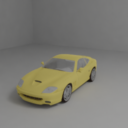

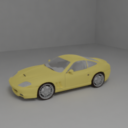

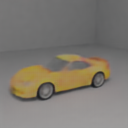

In [33]:
xb, yb = valid_loader.dataset[9]
show_image(xb)
show_image(yb)
xb = xb.unsqueeze(0)
show_image(model(xb.to(device)).squeeze(0))

In [34]:
train_loader_bis, valid_loader_bis, train_size_bis, val_size_bis = makeDataLoader(seed=0, asset_ids=asset_ids, input_angle=30, target_angle=150, batch_size=16, image_size=image_size)
model_bis = AutoEncoder(layer_channels=[[3], [48], [96], [192, 64]], image_size=image_size, bottleneck_channels=[4000]).to(device)

In [35]:
train_model(model_bis, train_loader_bis, valid_loader_bis, 0, 20)

Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.59it/s]


0 0.33418306428939104


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.47it/s]


1 0.3029326470568776


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.63it/s]


2 0.2835531570017338


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.51it/s]


3 0.2773073064163327


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.51it/s]


4 0.22631787601858377


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.48it/s]


5 0.22075781412422657


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.68it/s]


6 0.20008878922089934


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.66it/s]


7 0.2037490727379918


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.67it/s]


8 0.19908303767442703


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.52it/s]


9 0.19875891925767064


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.54it/s]


10 0.19882772071287036


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.58it/s]


11 0.19144809572026134


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.36it/s]


12 0.19788055587559938


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.54it/s]


13 0.19085050886496902


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.36it/s]


14 0.1905472967773676


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.44it/s]


15 0.19279280491173267


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.29it/s]


16 0.19742964999750257


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.45it/s]


17 0.19171219319105148


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.57it/s]


18 0.18717857543379068


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.52it/s]


19 0.18372484995052218


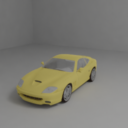

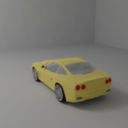

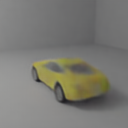

In [46]:
xb, yb = valid_loader_bis.dataset[9]
show_image(xb)
show_image(yb)
xb = xb.unsqueeze(0)
show_image(model_bis(xb.to(device)).squeeze(0))